In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import networkx as nx
import matplotlib.colors as mcolors
# warnings.simplefilter(action='ignore', category=FutureWarning)
# pd.options.display.max_rows = None
# pd.options.display.max_columns = None
import glob as glob
import math

#### read in csv amyloid pos and negative for adni and a4 


### sort the data into quartiles based on centiloid value

In [15]:
merged_adni_at_amypos_bi_harm = pd.read_csv('./adni/merged_adni_at_amy_pos_bi_harm.csv')
merged_a4_at_amypos_bi_harm = pd.read_csv('./a4/merged_a4_at_amy_pos_bi_harm.csv')

In [16]:
merged_adni_at_amypos_bi_harm

,RID,TRANSVERSETEMPORAL,SUPERIORTEMPORAL,INFERIORTEMPORAL,FUSIFORM,POSTERIORCINGULATE,INSULA,PERICALCARINE,PUTAMEN,PARAHIPPOCAMPAL,...,ACCUMBENS_AREA,LINGUAL,PALLIDUM,AMYGDALA,ROSTRALANTERIORCINGULATE,BANKSSTS,CUNEUS,MIDDLETEMPORAL,SUPERIORFRONTAL,PRECUNEUS
0,31,1.484,1.502,1.532,1.295,1.397,1.206,1.103,1.262,1.548,...,1.476,1.338,1.572,1.708,1.200,1.394,1.571,1.505,1.491,1.529
1,112,1.746,2.003,2.480,2.015,1.803,1.905,1.644,1.822,2.137,...,1.428,1.597,1.673,2.563,1.762,2.009,1.713,2.057,2.215,2.140
2,120,1.209,1.575,1.733,1.494,1.564,1.314,1.500,1.372,1.518,...,0.962,1.407,1.335,1.236,1.274,1.539,1.773,1.795,1.651,1.576
3,142,1.136,1.726,1.960,1.446,1.447,1.557,1.638,1.402,1.582,...,2.485,1.314,1.548,2.119,1.574,1.539,1.426,2.280,1.466,1.474
4,210,1.298,1.661,1.977,1.606,1.533,1.288,1.419,1.390,1.527,...,1.160,1.593,1.536,1.203,1.340,1.671,1.721,1.998,1.493,1.619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,6572,0.808,1.926,2.434,1.792,1.548,1.157,1.108,1.268,1.946,...,1.935,1.220,1.692,1.257,1.311,2.044,1.606,2.427,1.537,1.659
407,6575,1.215,1.400,1.574,1.400,1.323,1.333,1.066,1.394,1.673,...,1.613,1.303,1.533,1.797,1.348,1.304,1.494,1.552,1.420,1.360
408,6580,1.230,1.636,1.857,1.494,1.384,1.281,1.408,1.604,1.336,...,1.519,1.457,1.612,1.914,1.376,1.535,1.663,1.688,1.629,1.552
409,6581,0.997,1.378,1.613,1.284,1.183,1.121,0.995,1.440,1.372,...,1.366,1.191,1.632,1.054,1.253,1.198,1.274,1.574,1.343,1.186


#### sort adni data into centiloid 

In [17]:
# Calculate quartiles for each patient's 'CENTILOIDS' values
merged_adni_at_amypos_bi_harm['QUARTILE'] = pd.qcut(merged_adni_at_amypos_bi_harm['CENTILOIDS'], q=4, labels=False)

# Initialize empty DataFrames for each quartile
quartile_dfs = [pd.DataFrame(columns=merged_adni_at_amypos_bi_harm.columns) for _ in range(4)]

# Sort patients into quartile DataFrames
for index, row in merged_adni_at_amypos_bi_harm.iterrows():
    quartile_num = row['QUARTILE']
    quartile_dfs[quartile_num] = quartile_dfs[quartile_num].append(row, ignore_index=True)

# Remove the 'QUARTILE' column from each quartile DataFrame
for i in range(4):
    quartile_dfs[i] = quartile_dfs[i].drop(columns=['QUARTILE'])




/tmp/ipykernel_1152479/667071555.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quartile_dfs[quartile_num] = quartile_dfs[quartile_num].append(row, ignore_index=True)


#### further cleaning adni data (only bilateral (l/r hemi regions combined))
- has col names _VOLUME for the volume so drop these 
- they also have _SUVR so maybe could only keep these as a quality control check 
- the naming conventions are stuff like CTX_LH_SUPERIORFRONTAL_SUVR (there's a CTX_LH_SUPERIORFRONTAL_SUVR and CTX_RH_SUPERIORFRONTAL_SUVR for each) 
- looks like there's a CTX_SUPERIORFRONTAL_SUVR and then a CTX_LH_SUPERIORFRONTAL_SUVR and a CTX_RH_SUPERIORFRONTAL_SUVR
- so need to only keep the CTX_SUPERIORFRONTAL_SUVR ones (something like search start with CTX**) if only looking at bilateral brain regions (this correponds to the A4 naming convention "bi_* columns" )


### drop volume before doing anything else

##### create separate data frames based on the new quartiles

In [19]:
#divide into quartiles based on centiloids column 
#the thing is 903 total patients but I want to divide them into quartiles 

cent_low = quartile_dfs[0]
cent_med_low = quartile_dfs[1]
cent_med_high = quartile_dfs[2]
cent_high = quartile_dfs[3]


In [21]:
merged_adni_at_amypos_bi_harm[['CENTILOIDS','QUARTILE']]

,CENTILOIDS,QUARTILE
0,97.0,2
1,89.0,2
2,32.0,0
3,107.0,3
4,54.0,1
...,...,...
406,115.0,3
407,89.0,2
408,142.0,3
409,28.0,0


#### Quartiles seem reasonably well aligned with AD pathology 
- centiloids are scaled such that 0 is no pathology and 100 is advanced pathology, so plotting thr quartiles seem to be reasonably well aligned based on the histrogram plotted 
- classes are also numerically balanced

<AxesSubplot: >

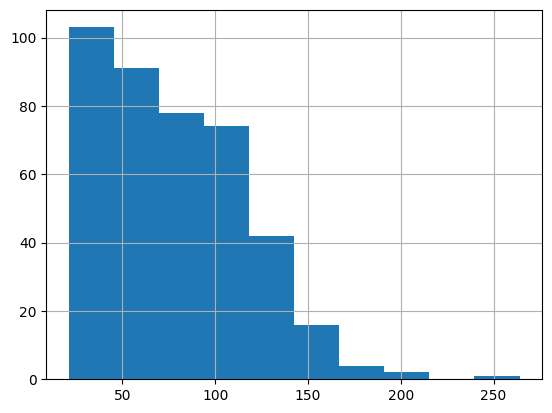

In [22]:
merged_adni_at_amypos_bi_harm['CENTILOIDS'].hist()

In [20]:
#classes are reasonably well balanced 
print(cent_low.shape)
print(cent_med_low.shape)
print(cent_med_high.shape)
print(cent_high.shape)


(103, 227)
(107, 227)
(100, 227)
(101, 227)


#### also check the centiloid ranges for each quartiles
##### it makes sense that the highest quartile would have the largest range because most of the data is cented 20-100 ish abased on the histogram 

In [23]:
low_range= [cent_low['CENTILOIDS'].min(),cent_low['CENTILOIDS'].max()]
med_low_range = [cent_med_low['CENTILOIDS'].min(),cent_med_low['CENTILOIDS'].max()]
med_high_range = [cent_med_high['CENTILOIDS'].min(),cent_med_high['CENTILOIDS'].max()]
high_range = [cent_high['CENTILOIDS'].min(),cent_high['CENTILOIDS'].max()]
print(f"centiloid range low amy pos quartile {low_range}")
print(f"centiloid range med low amy pos quartile {med_low_range}")
print(f"centiloid range med high amy pos quartile {med_high_range}")
print(f"centiloid range high amy pos quartile {high_range}")


centiloid range low amy pos quartile [21.0, 45.0]
centiloid range med low amy pos quartile [46.0, 75.0]
centiloid range med high amy pos quartile [76.0, 103.0]
centiloid range high amy pos quartile [104.0, 264.0]


##### save the adni centiloid quartiles csvs to use for graph construction

In [24]:
#save the quartile csvs 

cent_low.to_csv('./adni/adni_amy_tau_merged_cent_low_quartile.csv', index=False)
cent_med_low.to_csv('./adni/adni_amy_tau_merged_cent_med_low_quartile.csv', index=False)
cent_med_high.to_csv('./adni/adni_amy_tau_merged_cent_med_high_quartile.csv',index=False)
cent_high.to_csv('./adni/adni_amy_tau_merged_cent_high_quartile.csv',index=False)

- Only keep patients rows from most recent scan 


In [23]:
# #drop duplicate rows so that only the last visit row is still there 
# adni_amy_filtered = adni_amy.drop_duplicates(subset='RID',keep='last')
# #now it only has rows with the last visit 
# adni_amy_filtered = adni_amy.reset_index(drop=True)



# adni_amy['SCANDATE']= pd.to_datetime(adni_amy['SCANDATE'])
# #find most recent scan 
# most_recent_scan_date = adni_amy['SCANDATE'].max()
# #filter df to only include rows with most recent scan date 
# most_recent_scan = adni_amy[adni_amy['SCANDATE']==most_recent_scan_date]
# #select cols to keep 
# cols_to_keep = ['RID','SCANDATE','TRACER','CENTILOIDS']
# adni_amy_filtered = most_recent_scan[cols_to_keep]
# print(adni_amy_filtered)

* Task 1: 
* clean A4 data 
* I think that the A4_processed.csv has both amyloid and tau, but also includes patients with amyloid and no tau so just drop rows where the tau col is empty 
* A4_PETSUVR_PRV2_15_Aug2023 has id, visit code, and composite centiloid so use this for centiloid 

* TAUSUVR_15Aug2023 has the regional survs 


In [ ]:
#Now repeat the quartiles on a4

In [26]:
# Calculate quartiles for each patient's 'CENTILOIDS' values
merged_a4_at_amypos_bi_harm['quartile'] = pd.qcut(merged_a4_at_amypos_bi_harm['CENTILOIDS'], q=4, labels=False)

# Initialize empty DataFrames for each quartile
quartile_dfs = [pd.DataFrame(columns=merged_a4_at_amypos_bi_harm.columns) for _ in range(4)]

# Sort patients into quartile DataFrames
for index, row in merged_a4_at_amypos_bi_harm.iterrows():
    quartile_num = row['quartile']
    quartile_dfs[quartile_num] = quartile_dfs[quartile_num].append(row, ignore_index=True)

# Remove the 'QUARTILE' column from each quartile DataFrame
for i in range(4):
    quartile_dfs[i] = quartile_dfs[i].drop(columns=['quartile'])


/tmp/ipykernel_1152479/2932986344.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quartile_dfs[quartile_num] = quartile_dfs[quartile_num].append(row, ignore_index=True)


<AxesSubplot: >

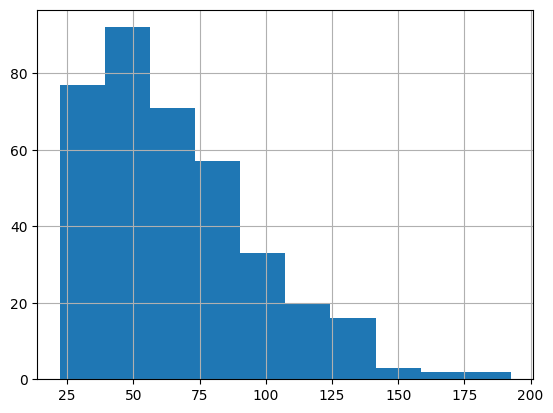

In [27]:
merged_a4_at_amypos_bi_harm['CENTILOIDS'].hist()

In [28]:
a4_cent_low = quartile_dfs[0]
a4_cent_med_low = quartile_dfs[1]
a4_cent_med_high = quartile_dfs[2]
a4_cent_high = quartile_dfs[3]

In [29]:
#classes are reasonably well balanced 
print(a4_cent_low.shape)
print(a4_cent_med_low.shape)
print(a4_cent_med_high.shape)
print(a4_cent_high.shape)

(101, 33)
(86, 33)
(94, 33)
(92, 33)


In [31]:
a4_low_range= [a4_cent_low['CENTILOIDS'].min(),a4_cent_low['CENTILOIDS'].max()]
a4_med_low_range = [a4_cent_med_low['CENTILOIDS'].min(),a4_cent_med_low['CENTILOIDS'].max()]
a4_med_high_range = [a4_cent_med_high['CENTILOIDS'].min(),a4_cent_med_high['CENTILOIDS'].max()]
a4_high_range = [a4_cent_high['CENTILOIDS'].min(),a4_cent_high['CENTILOIDS'].max()]
print(f"centiloid range low amy pos quartile {a4_low_range}")
print(f"centiloid range med low amy pos quartile {a4_med_low_range}")
print(f"centiloid range med high amy pos quartile {a4_med_high_range}")
print(f"centiloid range high amy pos quartile {a4_high_range}")

centiloid range low amy pos quartile [22.286, 42.424]
centiloid range med low amy pos quartile [44.255, 60.731]
centiloid range med high amy pos quartile [62.562, 82.699]
centiloid range high amy pos quartile [84.53, 192.541]


##### save a4 quartiles for graph construction 


In [32]:
#save the quartile csvs 
a4_cent_low.to_csv('./a4/a4_amy_tau_merged_cent_low_quartile.csv',index=False)
a4_cent_med_low.to_csv('./a4/a4_amy_tau_merged_cent_med_low_quartile.csv',index=False)
a4_cent_med_high.to_csv('./a4/a4_amy_tau_merged_cent_med_high_quartile.csv',index=False)
a4_cent_high.to_csv('./a4/a4_adni_amy_tau_merged_cent_high_quartile.csv',index=False)